In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

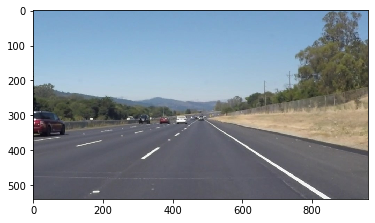

In [34]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(image)

In [67]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255 
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    firstRightX = 0
    firstLeftY = 0
    LastRightX = 0
    LastLeftY = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            # y = mx + b when m = slope
            x1n = int(slope*x1)
            y1n = int(slope*y1)
            x2n = int(slope*x2)
            y2n = int(slope*y2)
            if (x2 > x1): #ซ้าย
                cv2.line(img, (x1n + firstRightX, y1n + firstLeftY),(x2,y2), color, thickness)
            else: #ขวา 
                cv2.line(img, (x1,y1),(LastRightX + x2n, LastLeftY + y2n), color, thickness)
            firstRightX = x1
            firstLeftY = y1
            LastRightX = x2
            LastLeftY = y2
            #cv2.line(img, (x1,y1), (x2,y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):

    return cv2.addWeighted(initial_img, α, img, β, γ)

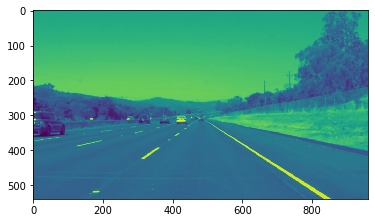

In [54]:
imgGray = grayscale(image)
plt.imshow(imgGray)

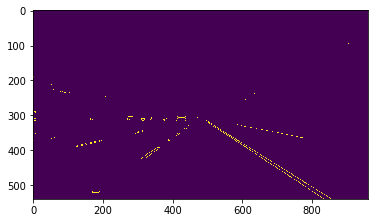

In [55]:
imgCanny = canny(imgGray,300, 400)
plt.imshow(imgCanny)

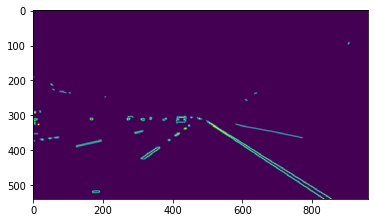

In [56]:
imgGuss = gaussian_blur(imgCanny, 7)
plt.imshow(imgGuss)

In [57]:
#set default 
imgShape = image.shape
img_height = image.shape[0]
img_width = image.shape[1]

maskScale = 0.6
maskWidth = 0.5

maskY = int(img_height * maskScale)
maskX = int(img_width * maskWidth)

In [58]:
#find vertices
vertices = np.array([[(0,img_height),(maskX, maskY), (maskX, maskY), (img_width,img_height)]])

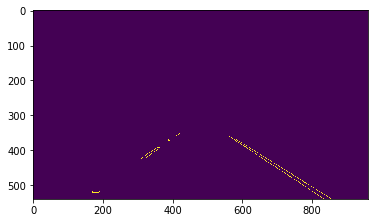

In [59]:
mask_edge = region_of_interest(imgCanny, vertices)
plt.imshow(mask_edge)

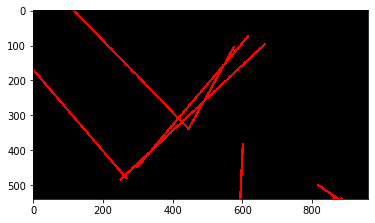

In [68]:
mask_hough = hough_lines(mask_edge, 1, np.pi/180, 18, 10, 40)
plt.imshow(mask_hough)

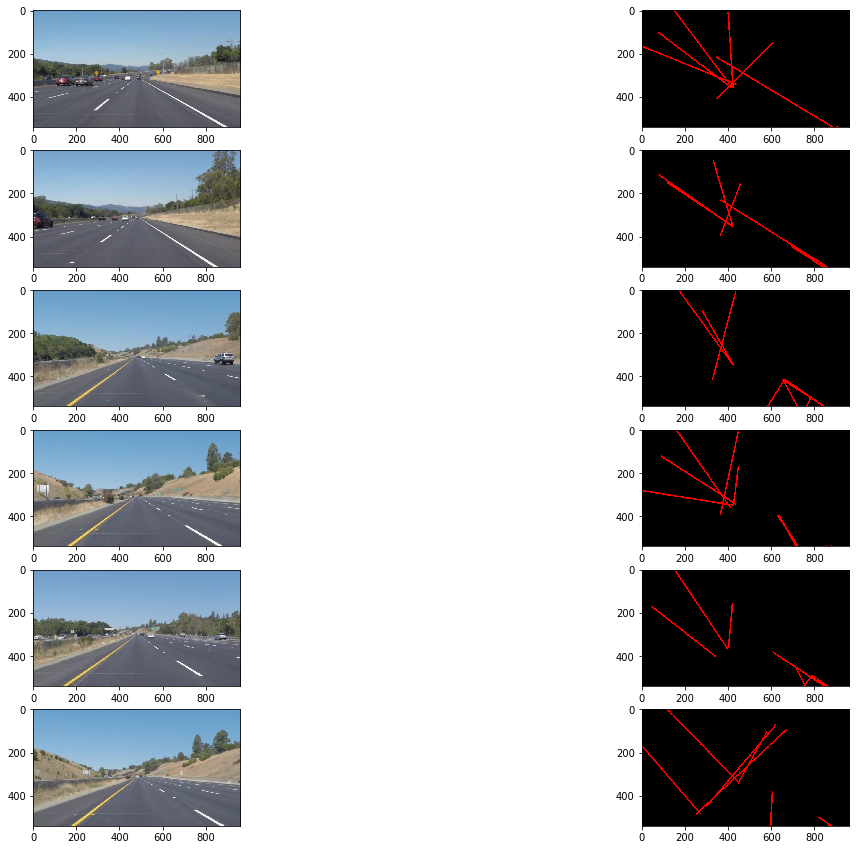

In [69]:
import os
listImg = os.listdir('test_images')
fig=plt.figure(figsize=(20, 15))
count = 0
for i in range(len(listImg)):
    image = mpimg.imread('test_images/' + listImg[i])
    imgGray = grayscale(image)
    imgCanny = canny(imgGray,300, 400)
    imgGauss = gaussian_blur(imgCanny, 3)
    mask_edge = region_of_interest(imgCanny, vertices)
    mask_hough = hough_lines(mask_edge, 1, np.pi/180, 18, 10, 40)
    fig.add_subplot(len(listImg), 2, count + 1)
    plt.imshow(image)
    fig.add_subplot(len(listImg), 2, count + 2)
    plt.imshow(mask_hough)
    count = count + 2
plt.show()

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [ ]:
def process_image(image):
    imgGray = grayscale(image)
    imgCanny = canny(imgGray,300, 400)
    imgGauss = gaussian_blur(imgCanny, 3)
    imgShape = image.shape
    img_height = image.shape[0]
    img_width = image.shape[1]

    maskScale = 0.6
    maskWidth = 0.5

    maskY = int(img_height * maskScale)
    maskX = int(img_width * maskWidth)

    vertices = np.array([[(0,img_height),(maskX, maskY), (maskX, maskY), (img_width,img_height)]])

    mask_edge = region_of_interest(imgCanny, vertices)

    mask_hough = hough_lines(mask_edge, 1, np.pi/180, 18, 10, 40)

    result_image = weighted_img(image, mask_hough)
    return result_image

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
dirName = 'test_videos_output'
if not os.path.exists(dirName):
        os.makedirs(dirName)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'

clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
process_image(image)
plt.imshow(process_image(image))

In [ ]:
shape = image.shape
shape = list(shape)
#axis dimmension
shape = tuple(shape)
blank_image = np.zeros(shape, np.float32)
plt.imshow(blank_image)